<a href="https://colab.research.google.com/github/dhkad/ATA/blob/main/Kidney_CTscan_images_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kidney CT Scan Classifier (Normal vs Tumor)

In [8]:

# STEP 1: Setup
!pip install tensorflow matplotlib scikit-learn

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.utils import plot_model


In [14]:

# STEP 2: Dataset Setup
# Mount Google Drive
from google.colab import files
import zipfile
import os

# Upload ZIP file Kidney_Cancer.zip
uploaded = files.upload()

# Extract
for filename in uploaded.keys():
    zip_path = f"/content/{filename}"
    extract_path = "/content/Kidney_Cancer"
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Verify extraction
os.listdir(extract_path)

# Set base_dir to the extracted folder
base_dir = extract_path
print(f"Dataset ready at: {base_dir}")


# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    horizontal_flip=True,
)

train_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='binary'
)

val_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='binary'
)

Saving Kidney Cancer.zip to Kidney Cancer.zip
Dataset ready at: /content/Kidney_Cancer
Found 8000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.


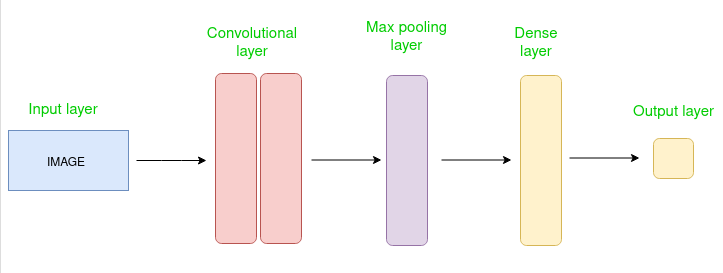

In [16]:
# STEP 3: Model 1 – Simple CNN from Scratch

cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=IMG_SIZE + (3,)), #three (Conv layer, MaxPooling layer) + flatter + dence layer
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.GlobalAveragePooling2D(),   # instead of Flatten()
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_cnn = cnn_model.fit(
    train_gen,
    epochs=2,
    validation_data=val_gen
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 1128s 2s/step - accuracy: 0.9898 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 1168s 2s/step - accuracy: 1.0000 - loss: 5.8389e-39 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

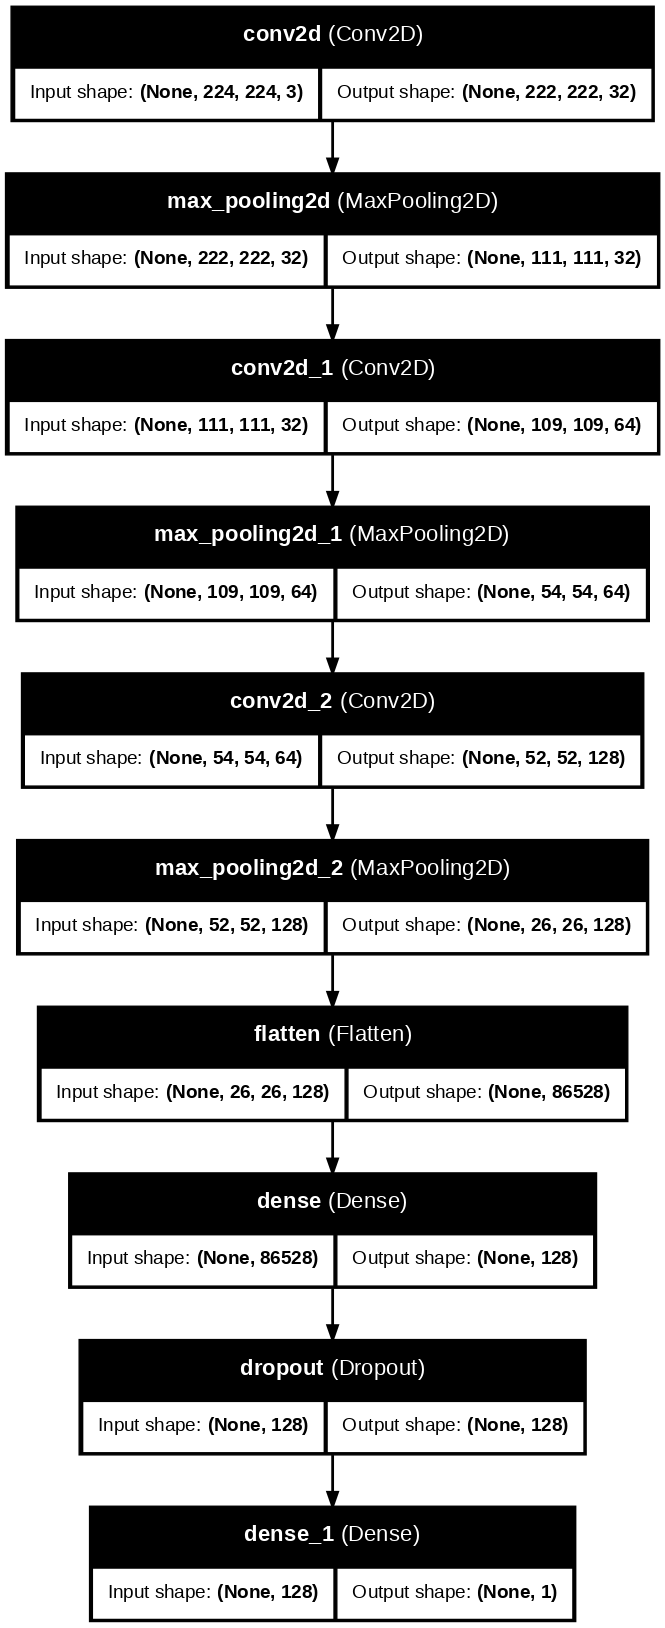

In [17]:
from tensorflow.keras.utils import plot_model

# Save a diagram of the model
plot_model(
    cnn_model,
    to_file="cnn_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=100
)


In [18]:
# STEP 4: Model 2 – Pretrained ResNet50

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # freeze base model

resnet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

resnet_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

history_resnet = resnet_model.fit(
    train_gen,
    epochs=2,
    validation_data=val_gen
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 1964s 4s/step - accuracy: 0.9829 - loss: 0.0334 - val_accuracy: 1.0000 - val_loss: 3.0444e-07
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 1988s 4s/step - accuracy: 1.0000 - loss: 1.2610e-05 - val_accuracy: 1.0000 - val_loss: 9.4797e-08


In [25]:
# STEP 5: Evaluate Models

val_gen.reset()
cnn_loss, cnn_acc = cnn_model.evaluate(val_gen)
resnet_loss, resnet_acc = resnet_model.evaluate(val_gen)

print(f"\nCNN Accuracy: {cnn_acc*100:.2f}%")
print(f"ResNet50 Accuracy: {resnet_acc*100:.2f}%")



125/125 ━━━━━━━━━━━━━━━━━━━━ 99s 786ms/step - accuracy: 1.0000 - loss: 0.0000e+00
125/125 ━━━━━━━━━━━━━━━━━━━━ 392s 3s/step - accuracy: 1.0000 - loss: 9.4087e-08

CNN Accuracy: 100.00%
ResNet50 Accuracy: 100.00%


In [26]:

# STEP 6: Save Trained Models (.h5)

save_dir = "C:/Users/Dhifaf/Documents/IT_HÖGSKOLAN_AI/Kidney_Cancer"
os.makedirs(save_dir, exist_ok=True)

cnn_path = os.path.join(save_dir, "kidney_cnn_model.h5")
resnet_path = os.path.join(save_dir, "kidney_resnet_model.h5")

cnn_model.save(cnn_path)
resnet_model.save(resnet_path)

print(f"CNN model saved at: {cnn_path}")
print(f"ResNet50 model saved at: {resnet_path}")


CNN model saved at: C:/Users/Dhifaf/Documents/IT_HÖGSKOLAN_AI/Kidney_Cancer/kidney_cnn_model.h5
ResNet50 model saved at: C:/Users/Dhifaf/Documents/IT_HÖGSKOLAN_AI/Kidney_Cancer/kidney_resnet_model.h5
